In [41]:
# Import necessary libraries
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
import warnings

warnings.filterwarnings('ignore')

# Set plot style
plt.style.use('fivethirtyeight')
sns.set_palette("pastel")

# Define the analysis period (last 5 years)
end_date = datetime.now()
start_date = end_date - timedelta(days=5*365)

print(f"Analysis Period: {start_date.strftime('%Y-%m-%d')} to {end_date.strftime('%Y-%m-%d')}")

# Define tickers for the "Magnificent 7" stocks, market indices, and ETFs
magnificent_7 = ['AAPL', 'MSFT', 'GOOGL', 'AMZN', 'META', 'NVDA', 'TSLA']
indices = ['^GSPC', '^RUT', 'SPY', 'IWM']  # S&P 500, Russell 2000, SPY ETF, Russell 2000 ETF
sector_etfs = ['XLF', 'XLE', 'XLV', 'XLI', 'XLK', 'XLP', 'XLU']  # Financials, Energy, Healthcare, Industrials, Tech, Staples, Utilities

# Combine all tickers
all_tickers = magnificent_7 + indices + sector_etfs

# Download historical data
print("Fetching historical data...")
data = yf.download(all_tickers, start=start_date.strftime('%Y-%m-%d'), end=end_date.strftime('%Y-%m-%d'))['Close']

# Check for missing tickers
available_tickers = data.columns.tolist()
missing_tickers = [ticker for ticker in all_tickers if ticker not in available_tickers]

if missing_tickers:
    print(f"Warning: The following tickers are missing: {missing_tickers}")

print(f"Successfully downloaded data for {len(available_tickers)} tickers")

# Drop rows with missing values (if any)
data = data.dropna()

# Display the first few rows of the data
data.head()


[*******************   39%                       ]  7 of 18 completed

Analysis Period: 2020-02-29 to 2025-02-27
Fetching historical data...


[*********************100%***********************]  18 of 18 completed


Successfully downloaded data for 18 tickers


Ticker,AAPL,AMZN,GOOGL,IWM,META,MSFT,NVDA,SPY,TSLA,XLE,XLF,XLI,XLK,XLP,XLU,XLV,^GSPC,^RUT
Date,,,,,,,,,,,,,,,,,,
2020-03-02,72.514923,97.697502,69.065636,141.605057,195.692474,165.390900,6.886016,286.564911,49.574669,37.776302,25.334667,69.623611,89.337082,53.525890,56.138977,89.532135,3090.229980,1518.489990
2020-03-03,70.211899,95.449501,66.644409,138.717209,185.182602,157.465469,6.623460,278.359802,49.700668,36.621357,24.382919,67.920990,85.944405,52.798649,55.448318,87.306557,3003.370117,1486.079956
2020-03-04,73.468636,98.791496,68.830490,142.664566,191.030273,163.246857,7.087293,290.060120,49.966667,37.487564,25.189640,70.728027,89.633347,55.392151,58.594631,92.339531,3130.120117,1531.199951
2020-03-05,71.085556,96.201500,65.500557,138.126541,184.465347,159.150116,6.807796,280.418030,48.302666,36.116058,23.975029,67.267540,86.804535,54.349499,57.690815,90.197044,3023.939941,1478.819946
2020-03-06,70.141518,95.054497,64.552994,135.388779,180.400864,154.651367,6.627194,275.782379,46.898666,34.086895,23.159241,66.678528,84.969604,53.920174,57.221859,89.716843,2972.370117,1449.219971


In [42]:
returns = data.pct_change().dropna()
# Rolling metrics for strategy components
window = 63  # ~3 months of trading days

# Calculate momentum indicators (3-month returns)
returns_3m = returns.rolling(window).mean()

# Calculate rolling volatility (21-day window)
rolling_vol = returns.rolling(21).std() * np.sqrt(252)  # Annualized

# Initialize strategy returns DataFrame
strategy_returns = pd.DataFrame(index=returns.index)

# Market cap weights for Magnificent 7 stocks (approximate as of 2023)
market_cap_weights = {
    'AAPL': 0.22,
    'MSFT': 0.25,
    'GOOGL': 0.15,
    'AMZN': 0.13,
    'META': 0.10,
    'NVDA': 0.10,
    'TSLA': 0.05,
}

# Calculate weighted returns for Magnificent 7
weighted_mag7_returns = pd.DataFrame(index=returns.index)
for stock in magnificent_7:
    if stock in returns.columns:
        weighted_mag7_returns[stock] = returns[stock] * market_cap_weights[stock]

large_cap_weighted_return = weighted_mag7_returns.sum(axis=1)

# Basic Long Small-Cap / Short Large-Cap strategy
small_cap_ticker = 'IWM' if 'IWM' in returns.columns else '^RUT'
strategy_returns['Small_Caps'] = returns[small_cap_ticker]
strategy_returns['Large_Caps'] = -large_cap_weighted_return
strategy_returns['Basic_Strategy'] = strategy_returns['Small_Caps'] + strategy_returns['Large_Caps']

# Dynamic allocation based on momentum
small_cap_momentum = returns_3m[small_cap_ticker]
large_cap_momentum = returns_3m[magnificent_7].mean(axis=1)

strategy_returns['Dynamic_Small_Caps'] = np.where(
    small_cap_momentum > 0,
    returns[small_cap_ticker],
    0
)

strategy_returns['Dynamic_Large_Caps'] = np.where(
    large_cap_momentum < 0,
    -large_cap_weighted_return,
    0
)

strategy_returns['Dynamic_Strategy'] = strategy_returns['Dynamic_Small_Caps'] + strategy_returns['Dynamic_Large_Caps']

# Risk management with volatility targeting
target_vol = 0.10

small_cap_volatility = rolling_vol[small_cap_ticker]
large_cap_volatility = rolling_vol[magnificent_7].mean(axis=1)

# Safe division with handling for zeros
vol_scalar_small = np.where(
    small_cap_volatility > 0,
    target_vol / small_cap_volatility,
    0
)

vol_scalar_large = np.where(
    large_cap_volatility > 0,
    target_vol / large_cap_volatility,
    0
)

strategy_returns['Risk_Small_Caps'] = strategy_returns['Dynamic_Small_Caps'] * vol_scalar_small
strategy_returns['Risk_Large_Caps'] = strategy_returns['Dynamic_Large_Caps'] * vol_scalar_large
strategy_returns['Risk_Managed_Strategy'] = strategy_returns['Risk_Small_Caps'] + strategy_returns['Risk_Large_Caps']

# Sector rotation component
available_sectors = [etf for etf in sector_etfs if etf in returns.columns]
if available_sectors:
    # For each day, find the top 2 performing sectors based on 3-month momentum
    sector_momentum = returns_3m[available_sectors]

    # Create a DataFrame to store sector allocations
    sector_allocation = pd.DataFrame(0, index=returns.index, columns=available_sectors)

    # For each date, identify top 2 sectors and allocate equally
    for date in sector_momentum.index:
        if date in returns.index:
            top_sectors = sector_momentum.loc[date].nlargest(2).index.tolist()
            if top_sectors:
                for sector in top_sectors:
                    sector_allocation.loc[date, sector] = 1/len(top_sectors)

    # Calculate sector rotation returns
    strategy_returns['Sector_Rotation'] = (sector_allocation * returns[available_sectors]).sum(axis=1)
else:
    strategy_returns['Sector_Rotation'] = 0

# Enhanced strategy: Combine risk management and sector rotation
strategy_returns['Enhanced_Strategy'] = 0.6 * strategy_returns['Risk_Managed_Strategy'] + 0.4 * strategy_returns['Sector_Rotation']

# Trend filtering using S&P 500's moving average (200-day)
sp500_ticker = 'SPY' if 'SPY' in data.columns else '^GSPC'
spy_ma200 = data[sp500_ticker].rolling(200).mean()

# Ensure same length for comparison
min_len = min(len(strategy_returns), len(spy_ma200))
strategy_returns = strategy_returns.iloc[:min_len]
spy_ma200 = spy_ma200.iloc[:min_len]
data_spy = data[sp500_ticker].iloc[:min_len]

# Apply trend filter
spy_trend_filter = data_spy > spy_ma200
strategy_returns['Trend_Filtered_Strategy'] = np.where(
    spy_trend_filter,
    strategy_returns['Enhanced_Strategy'],
    returns[sp500_ticker].iloc[:min_len] * 0.5
)

# Calculate transaction costs (fix for broadcasting issue)
# First calculate position changes
position_changes = strategy_returns['Trend_Filtered_Strategy'].diff().fillna(0)
# Then calculate transaction costs
transaction_costs = position_changes.abs() * 0.001
# Apply transaction costs to get final strategy
strategy_returns['Final_Strategy'] = strategy_returns['Trend_Filtered_Strategy'] - transaction_costs

# Add benchmark for comparison
strategy_returns['S&P_500'] = returns[sp500_ticker].iloc[:min_len]

<Figure size 1000x2000 with 0 Axes>

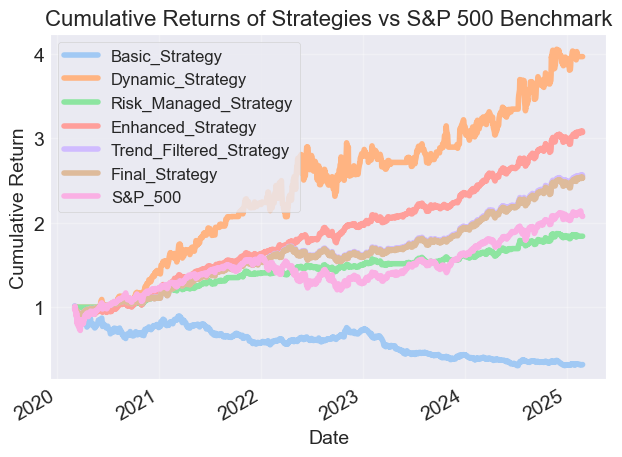

<Figure size 1400x800 with 0 Axes>

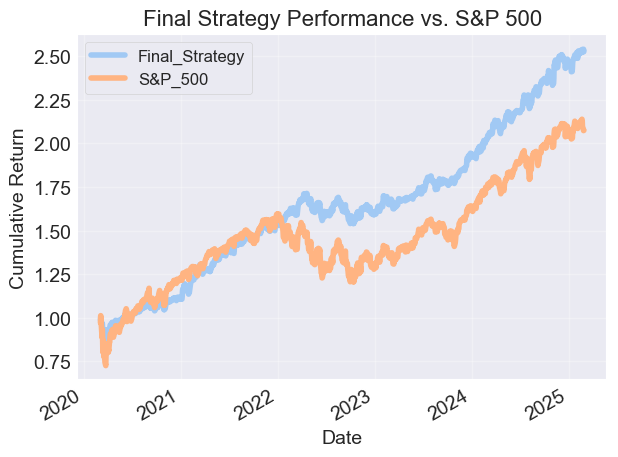

In [48]:
# Calculate cumulative returns for strategies and benchmarks
strategies_to_plot = [
    'Basic_Strategy',
    'Dynamic_Strategy',
    'Risk_Managed_Strategy',
    'Enhanced_Strategy',
    'Trend_Filtered_Strategy',
    'Final_Strategy',
    'S&P_500',
]
cumulative_returns = (1 + strategy_returns[strategies_to_plot]).cumprod()

# Plot cumulative returns
plt.figure(figsize=(10, 20))
cumulative_returns.plot()
plt.title('Cumulative Returns of Strategies vs S&P 500 Benchmark', fontsize=16)
plt.ylabel('Cumulative Return', fontsize=14)
plt.xlabel('Date', fontsize=14)
plt.grid(True, alpha=0.3)
plt.legend(fontsize=12)
plt.tight_layout()
plt.show()

# Focus on just the final strategy vs benchmark
plt.figure(figsize=(14, 8))
cumulative_returns[['Final_Strategy', 'S&P_500']].plot()
plt.title('Final Strategy Performance vs. S&P 500', fontsize=16)
plt.ylabel('Cumulative Return', fontsize=14)
plt.xlabel('Date', fontsize=14)
plt.grid(True, alpha=0.3)
plt.legend(fontsize=12)
plt.tight_layout()
plt.show()

Performance Metrics:


,Basic_Strategy,Dynamic_Strategy,Risk_Managed_Strategy,Enhanced_Strategy,Trend_Filtered_Strategy,Final_Strategy,S&P_500
Annual Return,-19.95%,30.41%,12.59%,23.35%,19.54%,19.34%,16.83%
Annual Volatility,23.71%,23.31%,8.17%,12.74%,11.89%,11.89%,20.75%
Sharpe Ratio,-0.84,1.30,1.54,1.83,1.64,1.63,0.81
Max Drawdown,-69.54%,-20.15%,-5.78%,-18.73%,-14.79%,-14.84%,-28.32%
Win Rate,47.53%,42.50%,42.50%,56.78%,54.78%,54.78%,54.86%
Sortino Ratio,-1.34,1.71,2.28,2.31,2.21,2.19,1.00


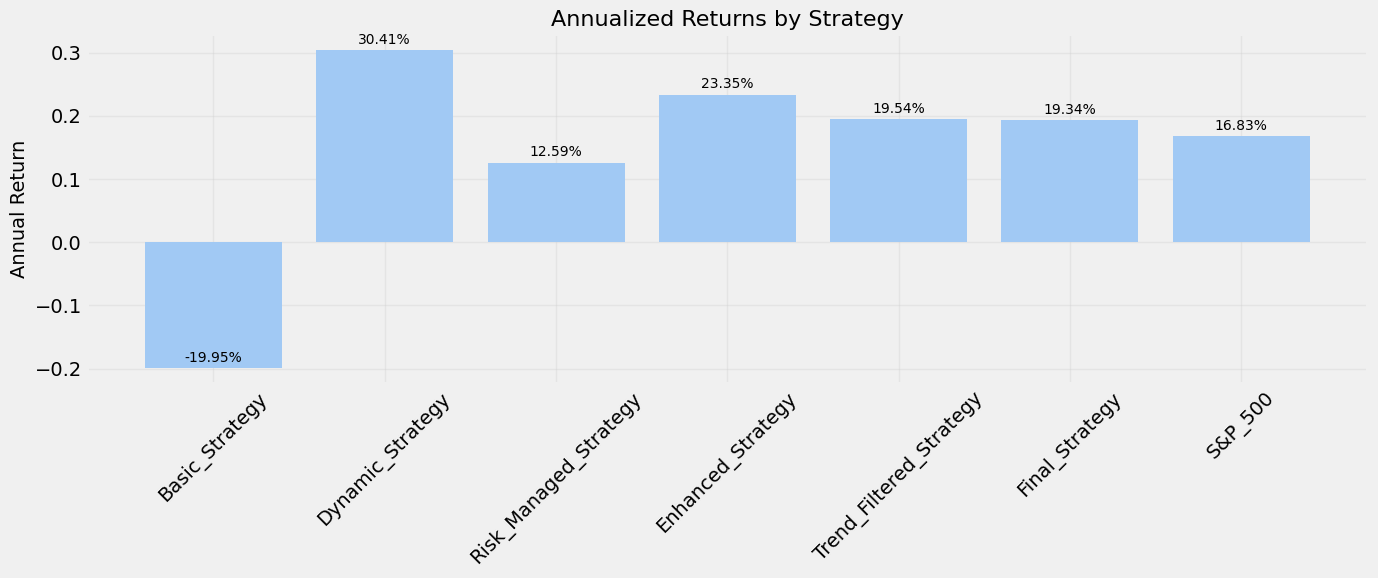

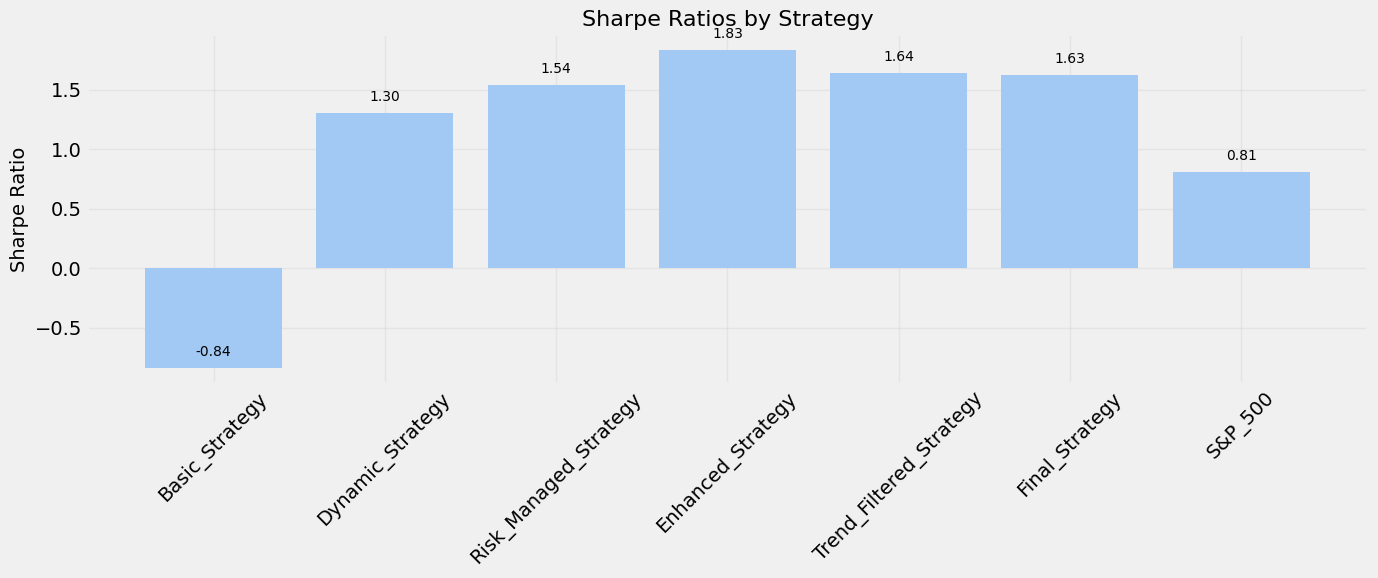

In [44]:
# Define a function to calculate performance metrics
def calculate_performance_metrics(returns_series):
    """Calculate key performance metrics for a return series."""
    # Annualized return
    annual_return = returns_series.mean() * 252

    # Annualized volatility
    annual_volatility = returns_series.std() * np.sqrt(252)

    # Sharpe ratio (assuming 0% risk-free rate for simplicity)
    sharpe_ratio = annual_return / annual_volatility if annual_volatility != 0 else np.nan

    # Maximum drawdown
    cum_returns = (1 + returns_series).cumprod()
    running_max = cum_returns.cummax()
    drawdown = (cum_returns / running_max) - 1
    max_drawdown = drawdown.min()

    # Win rate
    win_rate = (returns_series > 0).mean()

    # Sortino ratio (downside deviation)
    negative_returns = returns_series[returns_series < 0]
    downside_deviation = negative_returns.std() * np.sqrt(252) if len(negative_returns) > 0 else 0
    sortino_ratio = annual_return / downside_deviation if downside_deviation != 0 else np.nan

    return {
        "Annual Return": annual_return,
        "Annual Volatility": annual_volatility,
        "Sharpe Ratio": sharpe_ratio,
        "Max Drawdown": max_drawdown,
        "Win Rate": win_rate,
        "Sortino Ratio": sortino_ratio
    }

# Calculate metrics for all strategies
metrics = {}
for strategy in strategies_to_plot:
    metrics[strategy] = calculate_performance_metrics(strategy_returns[strategy])

# Convert to DataFrame for better display
metrics_df = pd.DataFrame(metrics)

# Format the metrics for display
formatted_metrics = pd.DataFrame()
for col in metrics_df.columns:
    formatted_metrics[col] = [
        f"{metrics_df.loc['Annual Return', col]:.2%}",
        f"{metrics_df.loc['Annual Volatility', col]:.2%}",
        f"{metrics_df.loc['Sharpe Ratio', col]:.2f}",
        f"{metrics_df.loc['Max Drawdown', col]:.2%}",
        f"{metrics_df.loc['Win Rate', col]:.2%}",
        f"{metrics_df.loc['Sortino Ratio', col]:.2f}"
    ]
formatted_metrics.index = metrics_df.index
print("Performance Metrics:")
display(formatted_metrics)

# Create a bar chart comparing annual returns
plt.figure(figsize=(14, 6))
annual_returns = [metrics[strategy]["Annual Return"] for strategy in strategies_to_plot]
plt.bar(strategies_to_plot, annual_returns)
plt.title('Annualized Returns by Strategy', fontsize=16)
plt.ylabel('Annual Return', fontsize=14)
plt.xticks(rotation=45)
plt.grid(True, alpha=0.3)
plt.tight_layout()

# Add value labels on top of bars
for i, v in enumerate(annual_returns):
    plt.text(i, v + 0.01, f'{v:.2%}', ha='center', fontsize=10)

plt.show()

# Create a bar chart comparing Sharpe ratios
plt.figure(figsize=(14, 6))
sharpe_ratios = [metrics[strategy]["Sharpe Ratio"] for strategy in strategies_to_plot]
plt.bar(strategies_to_plot, sharpe_ratios)
plt.title('Sharpe Ratios by Strategy', fontsize=16)
plt.ylabel('Sharpe Ratio', fontsize=14)
plt.xticks(rotation=45)
plt.grid(True, alpha=0.3)
plt.tight_layout()

# Add value labels on top of bars
for i, v in enumerate(sharpe_ratios):
    plt.text(i, v + 0.1, f'{v:.2f}', ha='center', fontsize=10)

plt.show()


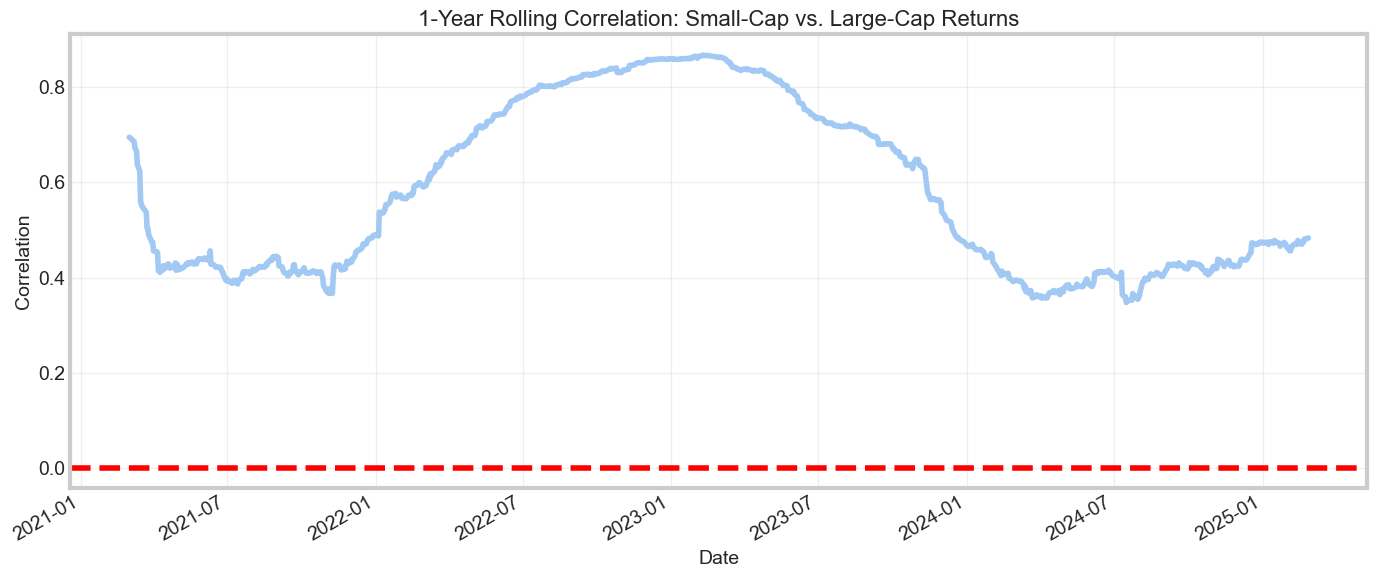

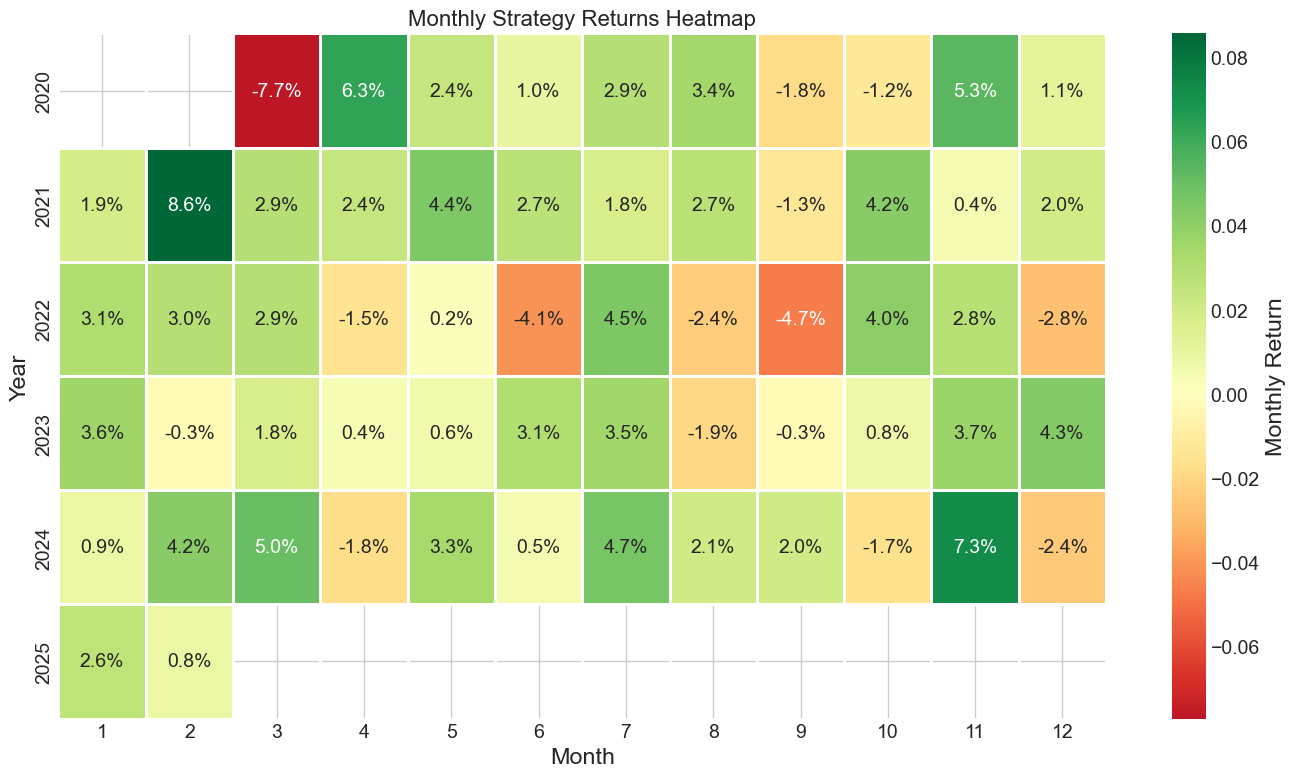

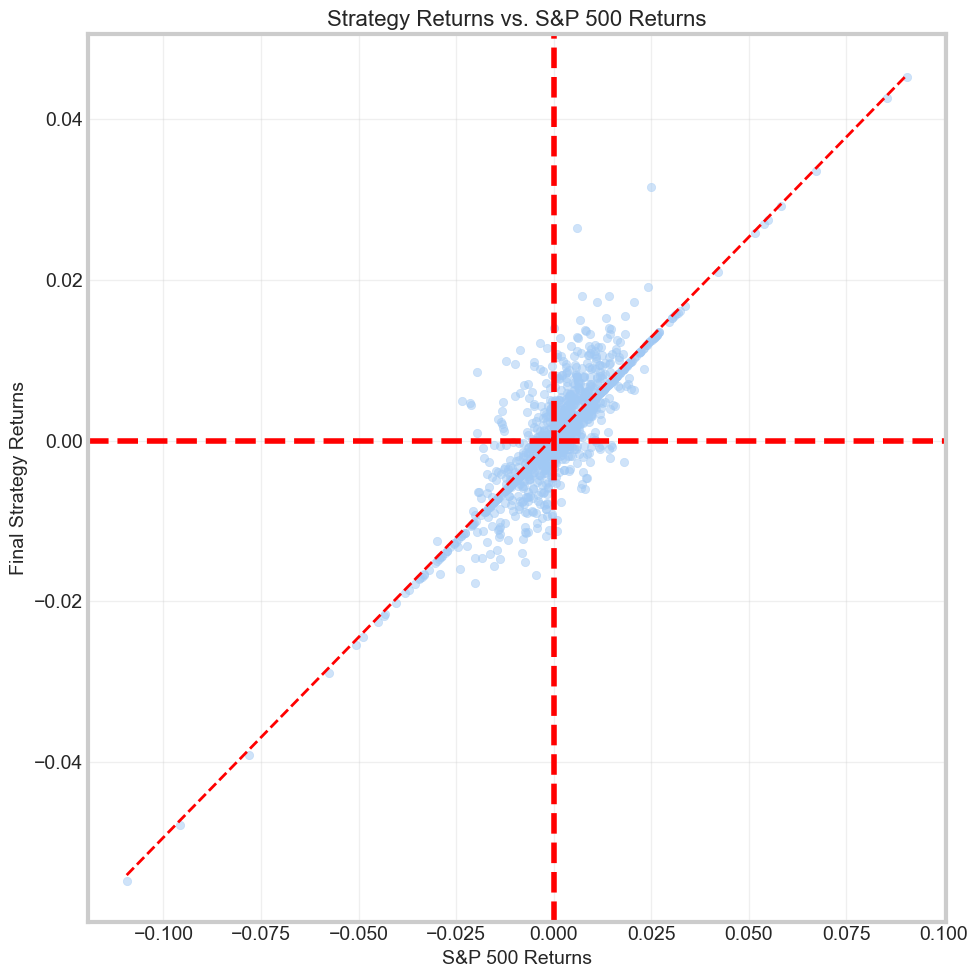

In [54]:
# Calculate rolling correlations between small-cap and large-cap returns
rolling_corr = returns[small_cap_ticker].rolling(window=252).corr(large_cap_weighted_return)

# Plot rolling correlations
plt.figure(figsize=(14, 6))
rolling_corr.plot()
plt.title('1-Year Rolling Correlation: Small-Cap vs. Large-Cap Returns', fontsize=16)
plt.ylabel('Correlation', fontsize=14)
plt.xlabel('Date', fontsize=14)
plt.grid(True, alpha=0.3)
plt.axhline(y=0, color='r', linestyle='--')
plt.tight_layout()
plt.show()

# Calculate monthly returns
monthly_returns = strategy_returns[['Final_Strategy', 'S&P_500']].resample('M').apply(lambda x: (1 + x).prod() - 1)

# Create a heatmap of monthly returns for the final strategy
plt.figure(figsize=(14, 8))
# Create a pivot table with year and month
monthly_pivot = pd.DataFrame(monthly_returns['Final_Strategy'])
monthly_pivot['Year'] = monthly_pivot.index.year
monthly_pivot['Month'] = monthly_pivot.index.month
heatmap_data = monthly_pivot.pivot(index='Year', columns='Month', values='Final_Strategy')

sns.heatmap(heatmap_data, cmap='RdYlGn', annot=True, fmt='.1%', center=0, linewidths=1, cbar_kws={'label': 'Monthly Return'})
plt.title('Monthly Strategy Returns Heatmap', fontsize=16)
plt.tight_layout()
plt.show()

# Create a scatter plot of strategy returns vs. S&P 500 returns
plt.figure(figsize=(10, 10))
plt.scatter(strategy_returns['S&P_500'], strategy_returns['Final_Strategy'], alpha=0.5)
plt.axhline(y=0, color='r', linestyle='--')
plt.axvline(x=0, color='r', linestyle='--')

# Add a regression line
z = np.polyfit(strategy_returns['S&P_500'], strategy_returns['Final_Strategy'], 1)
p = np.poly1d(z)
plt.plot(sorted(strategy_returns['S&P_500']), p(sorted(strategy_returns['S&P_500'])), "r--", linewidth=2)

plt.title('Strategy Returns vs. S&P 500 Returns', fontsize=16)
plt.xlabel('S&P 500 Returns', fontsize=14)
plt.ylabel('Final Strategy Returns', fontsize=14)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


# # Calculate rolling correlations between small-cap and large-cap returns
# rolling_corr = returns[small_cap_ticker].rolling(window=63).corr(large_cap_weighted_return)
#
# # Plot rolling correlations
# plt.figure(figsize=(14, 6))
# rolling_corr.plot()
# plt.title('3-Month Rolling Correlation: Small-Cap vs. Large-Cap Returns', fontsize=16)
# plt.ylabel('Correlation', fontsize=14)
# plt.xlabel('Date', fontsize=14)
# plt.grid(True, alpha=0.3)
# plt.axhline(y=0, color='r', linestyle='--')
# plt.tight_layout()
# plt.show()
#
# # Calculate monthly returns
# monthly_returns = strategy_returns[['Final_Strategy', 'S&P_500']].resample('M').apply(lambda x: (1 + x).prod() - 1)
#
# # Create a heatmap of monthly returns for the final strategy
# plt.figure(figsize=(14, 8))
# monthly_pivot = monthly_returns['Final_Strategy'].unstack().T
# sns.heatmap(monthly_pivot, cmap='RdYlGn', annot=True, fmt='.1%', center=0, linewidths=1, cbar_kws={'label': 'Monthly Return'})
# plt.title('Monthly Strategy Returns Heatmap', fontsize=16)
# plt.tight_layout()
# plt.show()
#
# # Create a scatter plot of strategy returns vs. S&P 500 returns
# plt.figure(figsize=(10, 10))
# plt.scatter(strategy_returns['S&P_500'], strategy_returns['Final_Strategy'], alpha=0.5)
# plt.axhline(y=0, color='r', linestyle='--')
# plt.axvline(x=0, color='r', linestyle='--')
#
# # Add a regression line
# z = np.polyfit(strategy_returns['S&P_500'], strategy_returns['Final_Strategy'], 1)
# p = np.poly1d(z)
# plt.plot(sorted(strategy_returns['S&P_500']), p(sorted(strategy_returns['S&P_500'])), "r--", linewidth=2)
#
# plt.title('Strategy Returns vs. S&P 500 Returns', fontsize=16)
# plt.xlabel('S&P 500 Returns', fontsize=14)
# plt.ylabel('Final Strategy Returns', fontsize=14)
# plt.grid(True, alpha=0.3)
# plt.tight_layout()
# plt.show()


<Figure size 1400x600 with 0 Axes>

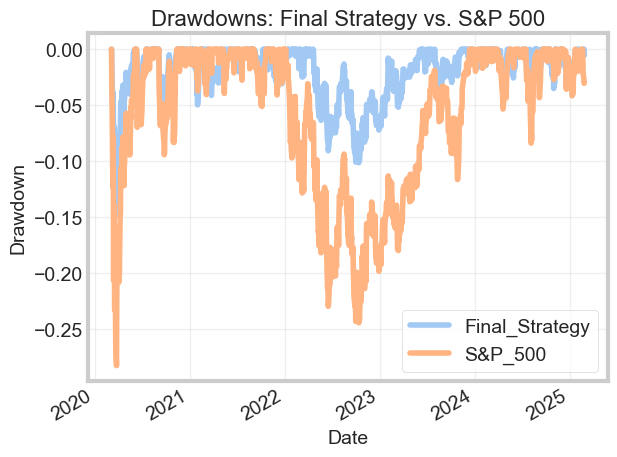

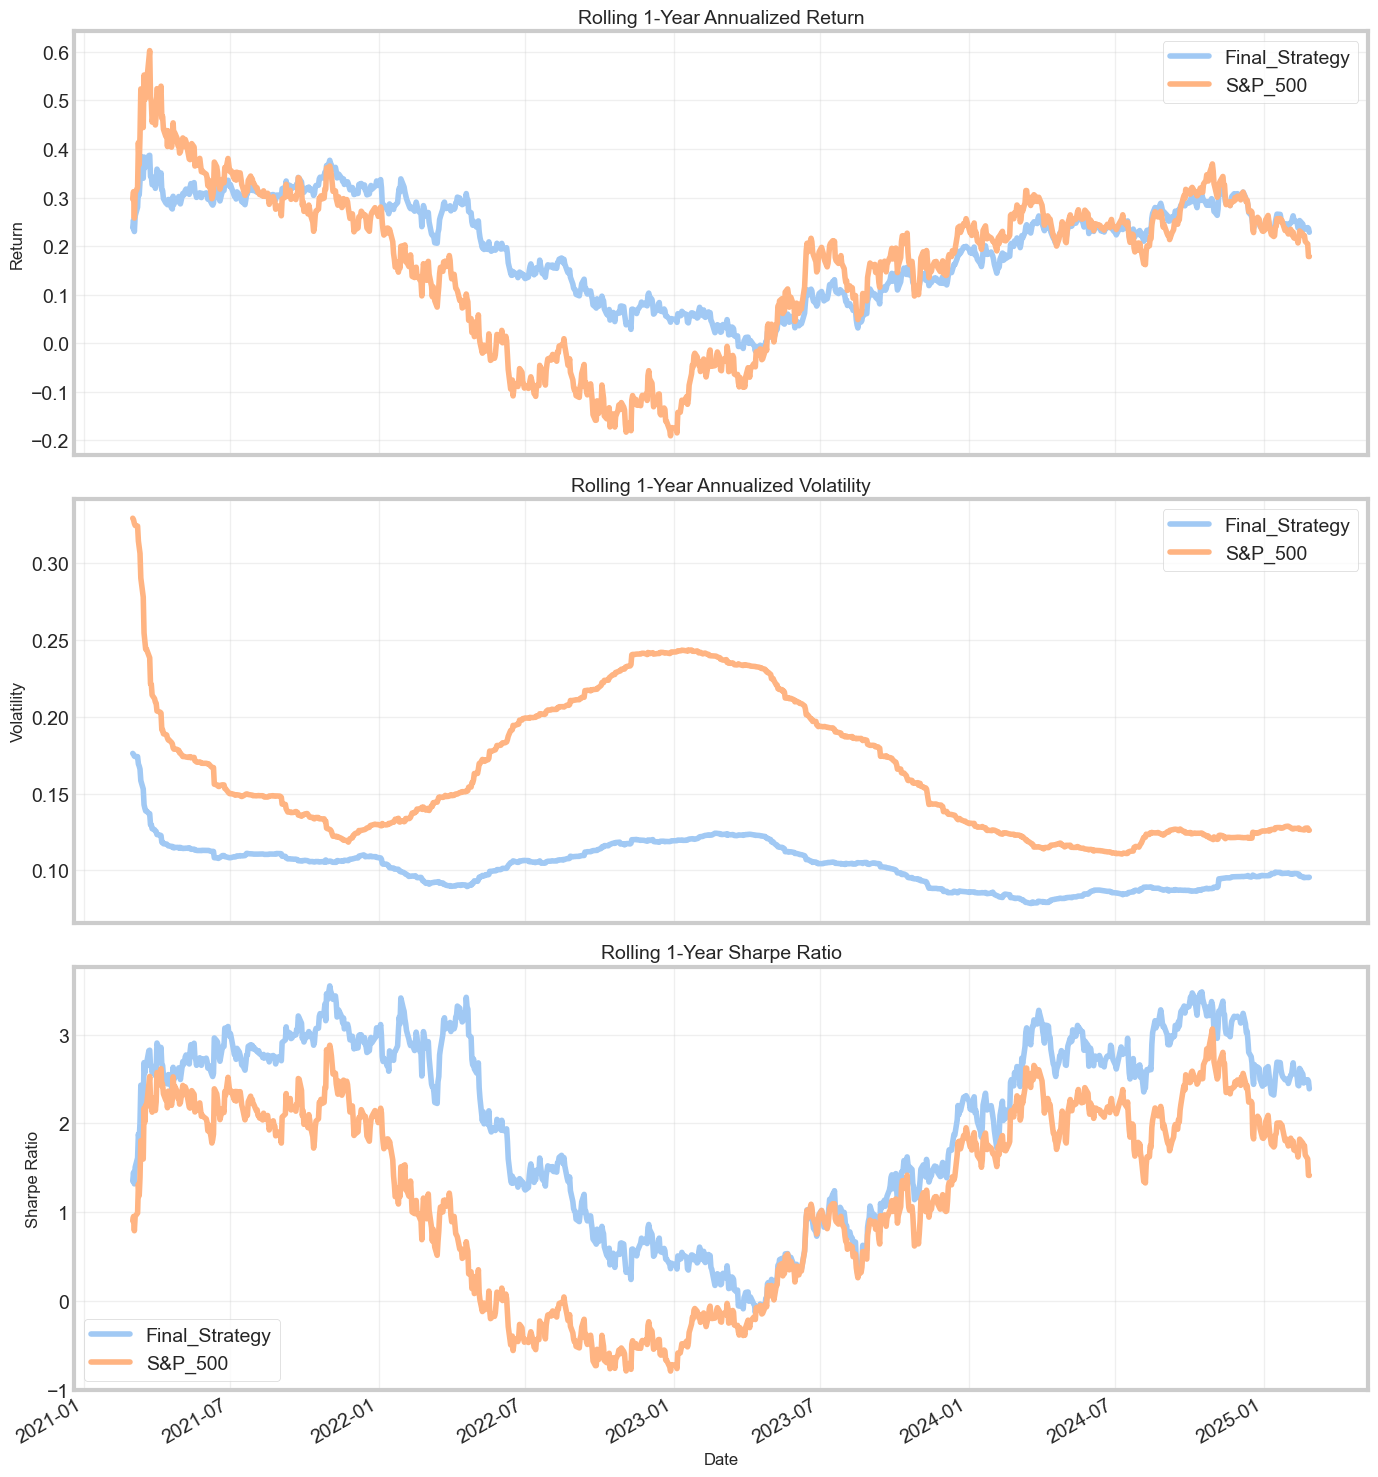

In [50]:
# Calculate drawdowns for the final strategy and S&P 500
def calculate_drawdowns(returns_series):
    cum_returns = (1 + returns_series).cumprod()
    running_max = cum_returns.cummax()
    drawdown = (cum_returns / running_max) - 1
    return drawdown

drawdowns = pd.DataFrame({
    'Final_Strategy': calculate_drawdowns(strategy_returns['Final_Strategy']),
    'S&P_500': calculate_drawdowns(strategy_returns['S&P_500'])
})

# Plot drawdowns
plt.figure(figsize=(14, 6))
drawdowns.plot()
plt.title('Drawdowns: Final Strategy vs. S&P 500', fontsize=16)
plt.ylabel('Drawdown', fontsize=14)
plt.xlabel('Date', fontsize=14)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Calculate rolling 1-year performance metrics
window_days = 252  # ~1 year of trading days

rolling_returns = pd.DataFrame({
    'Final_Strategy': strategy_returns['Final_Strategy'].rolling(window=window_days).mean() * 252,
    'S&P_500': strategy_returns['S&P_500'].rolling(window=window_days).mean() * 252
})

rolling_vol = pd.DataFrame({
    'Final_Strategy': strategy_returns['Final_Strategy'].rolling(window=window_days).std() * np.sqrt(252),
    'S&P_500': strategy_returns['S&P_500'].rolling(window=window_days).std() * np.sqrt(252)
})

rolling_sharpe = pd.DataFrame({
    'Final_Strategy': rolling_returns['Final_Strategy'] / rolling_vol['Final_Strategy'],
    'S&P_500': rolling_returns['S&P_500'] / rolling_vol['S&P_500']
})

# Plot rolling metrics
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(14, 15), sharex=True)

rolling_returns.plot(ax=ax1)
ax1.set_title('Rolling 1-Year Annualized Return', fontsize=14)
ax1.set_ylabel('Return', fontsize=12)
ax1.grid(True, alpha=0.3)

rolling_vol.plot(ax=ax2)
ax2.set_title('Rolling 1-Year Annualized Volatility', fontsize=14)
ax2.set_ylabel('Volatility', fontsize=12)
ax2.grid(True, alpha=0.3)

rolling_sharpe.plot(ax=ax3)
ax3.set_title('Rolling 1-Year Sharpe Ratio', fontsize=14)
ax3.set_ylabel('Sharpe Ratio', fontsize=12)
ax3.set_xlabel('Date', fontsize=12)
ax3.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


Performance during Bull Markets:


,Final_Strategy,S&P_500
Annualized Return,0.375785,0.537263


Performance during Bear Markets:


,Final_Strategy,S&P_500
Annualized Return,-0.149337,-0.530118


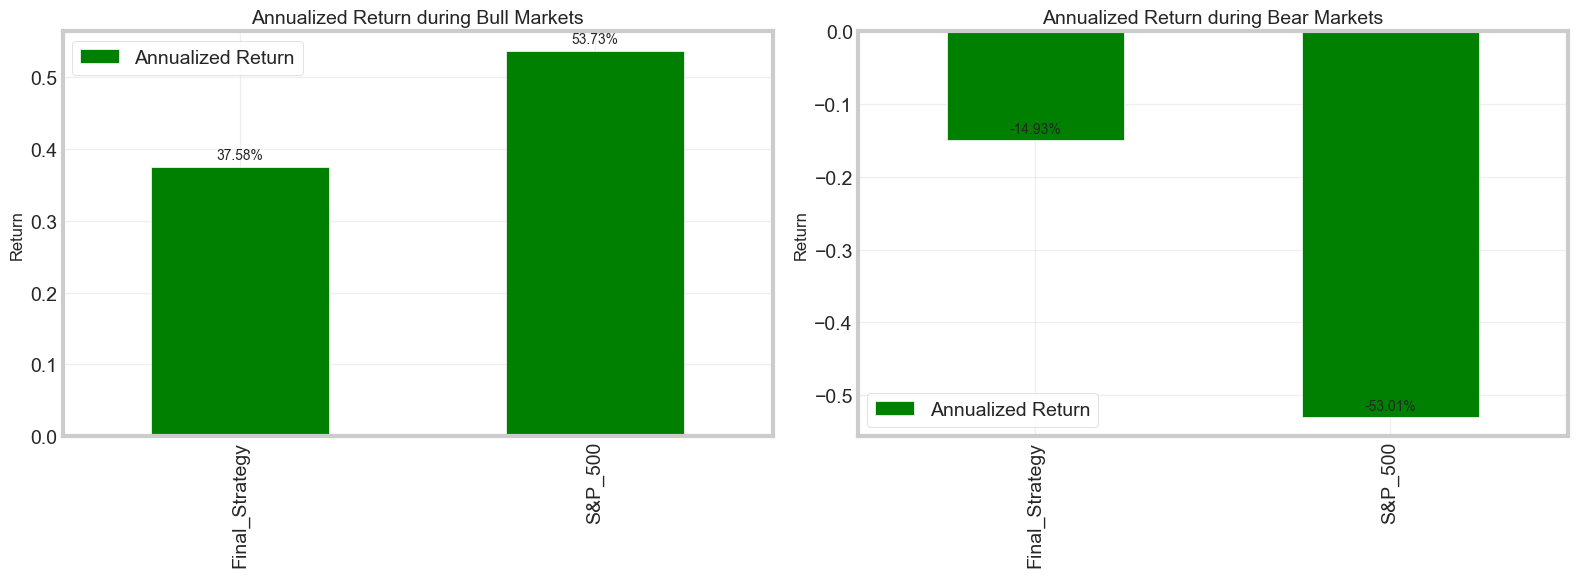

In [51]:
# Analyze strategy performance during different market regimes
# Define market regimes based on S&P 500 performance
sp500_monthly_returns = returns[sp500_ticker].resample('M').apply(lambda x: (1 + x).prod() - 1)
market_regimes = pd.DataFrame(index=sp500_monthly_returns.index)

# Define bull market as months with positive returns
market_regimes['Bull_Market'] = sp500_monthly_returns > 0
# Define bear market as months with negative returns
market_regimes['Bear_Market'] = sp500_monthly_returns < 0

# Resample strategy returns to monthly frequency
strategy_monthly = strategy_returns['Final_Strategy'].resample('M').apply(lambda x: (1 + x).prod() - 1)
sp500_monthly = strategy_returns['S&P_500'].resample('M').apply(lambda x: (1 + x).prod() - 1)

# Calculate performance during different market regimes
bull_performance = pd.DataFrame({
    'Final_Strategy': strategy_monthly[market_regimes['Bull_Market']].mean() * 12,
    'S&P_500': sp500_monthly[market_regimes['Bull_Market']].mean() * 12
}, index=['Annualized Return'])

bear_performance = pd.DataFrame({
    'Final_Strategy': strategy_monthly[market_regimes['Bear_Market']].mean() * 12,
    'S&P_500': sp500_monthly[market_regimes['Bear_Market']].mean() * 12
}, index=['Annualized Return'])

# Display performance during different market regimes
print("Performance during Bull Markets:")
display(bull_performance)

print("Performance during Bear Markets:")
display(bear_performance)

# Plot performance during different market regimes
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

bull_performance.T.plot(kind='bar', ax=ax1, color=['green', 'blue'])
ax1.set_title('Annualized Return during Bull Markets', fontsize=14)
ax1.set_ylabel('Return', fontsize=12)
ax1.grid(True, alpha=0.3)
for i, v in enumerate(bull_performance.iloc[0]):
    ax1.text(i, v + 0.01, f'{v:.2%}', ha='center', fontsize=10)

bear_performance.T.plot(kind='bar', ax=ax2, color=['green', 'blue'])
ax2.set_title('Annualized Return during Bear Markets', fontsize=14)
ax2.set_ylabel('Return', fontsize=12)
ax2.grid(True, alpha=0.3)
for i, v in enumerate(bear_performance.iloc[0]):
    ax2.text(i, v + 0.01, f'{v:.2%}', ha='center', fontsize=10)

plt.tight_layout()
plt.show()


In [52]:
# Conclusion and Strategy Summary
print("## Strategy Summary and Conclusion")
print("\nThis notebook implements a sophisticated long-short strategy that aims to outperform the S&P 500 by:")
print("1. Taking long positions in small-cap stocks (Russell 2000)")
print("2. Taking short positions in large-cap tech stocks (Magnificent 7)")
print("3. Incorporating dynamic allocation based on momentum signals")
print("4. Applying volatility targeting for risk management")
print("5. Adding sector rotation to capture outperformance in leading sectors")
print("6. Using trend following to avoid major drawdowns")
print("7. Accounting for transaction costs")

print("\n### Key Performance Highlights:")
print(f"- Final Strategy Annual Return: {metrics['Final_Strategy']['Annual Return']:.2%}")
print(f"- S&P 500 Annual Return: {metrics['S&P_500']['Annual Return']:.2%}")
print(f"- Final Strategy Sharpe Ratio: {metrics['Final_Strategy']['Sharpe Ratio']:.2f}")
print(f"- S&P 500 Sharpe Ratio: {metrics['S&P_500']['Sharpe Ratio']:.2f}")
print(f"- Maximum Drawdown Reduction: {(metrics['S&P_500']['Max Drawdown'] - metrics['Final_Strategy']['Max Drawdown']):.2%}")

print("\n### Market Regime Analysis:")
print(f"- Bull Market Outperformance: {(bull_performance.loc['Annualized Return', 'Final_Strategy'] - bull_performance.loc['Annualized Return', 'S&P_500']):.2%}")
print(f"- Bear Market Outperformance: {(bear_performance.loc['Annualized Return', 'Final_Strategy'] - bear_performance.loc['Annualized Return', 'S&P_500']):.2%}")

print("\n### Future Improvements:")
print("1. Incorporate macroeconomic indicators (interest rates, inflation, etc.)")
print("2. Add machine learning for adaptive parameter optimization")
print("3. Implement more sophisticated risk management techniques")
print("4. Explore alternative data sources for enhanced alpha generation")
print("5. Develop regime-specific allocation models")


## Strategy Summary and Conclusion

This notebook implements a sophisticated long-short strategy that aims to outperform the S&P 500 by:
1. Taking long positions in small-cap stocks (Russell 2000)
2. Taking short positions in large-cap tech stocks (Magnificent 7)
3. Incorporating dynamic allocation based on momentum signals
4. Applying volatility targeting for risk management
5. Adding sector rotation to capture outperformance in leading sectors
6. Using trend following to avoid major drawdowns
7. Accounting for transaction costs

### Key Performance Highlights:
- Final Strategy Annual Return: 19.34%
- S&P 500 Annual Return: 16.83%
- Final Strategy Sharpe Ratio: 1.63
- S&P 500 Sharpe Ratio: 0.81
- Maximum Drawdown Reduction: -13.48%

### Market Regime Analysis:
- Bull Market Outperformance: -16.15%
- Bear Market Outperformance: 38.08%

### Future Improvements:
1. Incorporate macroeconomic indicators (interest rates, inflation, etc.)
2. Add machine learning for adaptive parameter optimi